# <center> **Consumer Behavior and Shopping Habits Research**

# <center> *Let's begin!*

## 1. Import libraries

In [1]:
import numpy as np
import pandas as pd

import functions as funcs

import matplotlib.pyplot as plt
import seaborn as sns 

plt.style.use('bmh')

import warnings
warnings.filterwarnings('ignore')

## 2. Read Data

In [2]:
data = pd.read_csv('data/shopping_behavior_updated.csv')

data

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,3896,40,Female,Hoodie,Clothing,28,Virginia,L,Turquoise,Summer,4.2,No,2-Day Shipping,No,No,32,Venmo,Weekly
3896,3897,52,Female,Backpack,Accessories,49,Iowa,L,White,Spring,4.5,No,Store Pickup,No,No,41,Bank Transfer,Bi-Weekly
3897,3898,46,Female,Belt,Accessories,33,New Jersey,L,Green,Spring,2.9,No,Standard,No,No,24,Venmo,Quarterly
3898,3899,44,Female,Shoes,Footwear,77,Minnesota,S,Brown,Summer,3.8,No,Express,No,No,24,Venmo,Weekly


In [3]:
funcs.get_data_info(data) 

,Nulls,Uniques,Dtypes
Customer ID,0.0,3900,int64
Age,0.0,53,int64
Gender,0.0,2,object
Item Purchased,0.0,25,object
Category,0.0,4,object
Purchase Amount (USD),0.0,81,int64
Location,0.0,50,object
Size,0.0,4,object
Color,0.0,25,object
Season,0.0,4,object


In [4]:
data.describe(exclude='object').round(2) 

,Customer ID,Age,Purchase Amount (USD),Review Rating,Previous Purchases
count,3900.00,3900.00,3900.00,3900.00,3900.00
mean,1950.50,44.07,59.76,3.75,25.35
std,1125.98,15.21,23.69,0.72,14.45
min,1.00,18.00,20.00,2.50,1.00
25%,975.75,31.00,39.00,3.10,13.00
50%,1950.50,44.00,60.00,3.70,25.00
75%,2925.25,57.00,81.00,4.40,38.00
max,3900.00,70.00,100.00,5.00,50.00


In [5]:
data.describe(include='object').round(2) 

,Gender,Item Purchased,Category,Location,Size,Color,Season,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Payment Method,Frequency of Purchases
count,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900
unique,2,25,4,50,4,25,4,2,6,2,2,6,7
top,Male,Blouse,Clothing,Montana,M,Olive,Spring,No,Free Shipping,No,No,PayPal,Every 3 Months
freq,2652,171,1737,96,1755,177,999,2847,675,2223,2223,677,584


> There are no Null values in our data

# <center> *Here comes the EDA*

In [6]:
# I delete this column 
data.drop('Customer ID', axis=1, inplace=True)

## Numeric data

In [7]:
def show_histplot(column, data=data):
    x = data[column]
    
    if x.max() % 10 != 0:
        bins = x.max().astype(int)
    else:
        bins = (x.max() - x.min()).astype(int) 
    
    plt.figure(figsize=(10, 5))
    sns.histplot(data, 
                 x=x, 
                 kde=True, 
                 bins=bins)

    plt.show()
    

for col in data.columns:
    if data[col].dtype != 'object':
        print(col)

Age
Purchase Amount (USD)
Review Rating
Previous Purchases


### *Age*

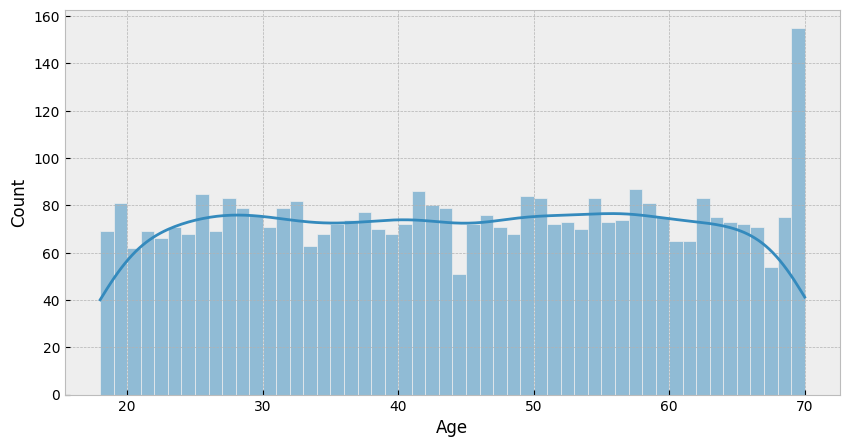

In [8]:
show_histplot('Age')

### *Purchase Amount (USD)*

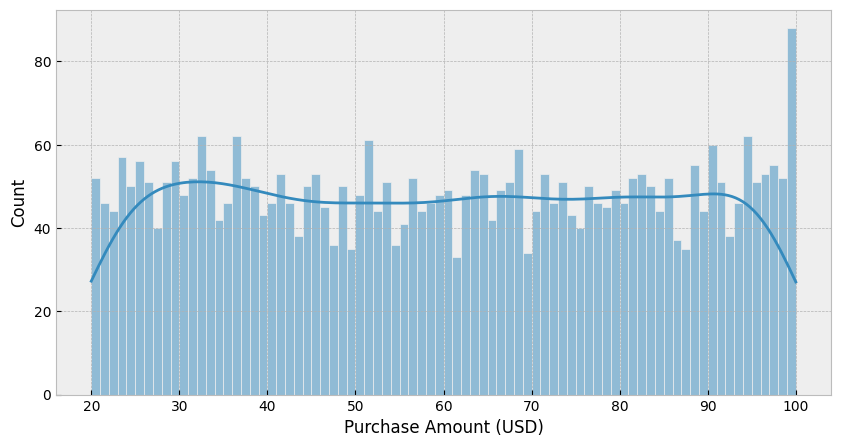

In [9]:
show_histplot('Purchase Amount (USD)') 

### *Review Rating*

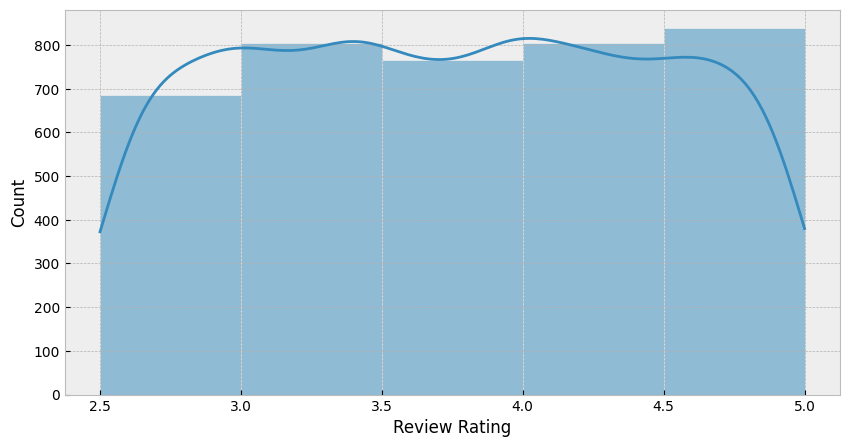

In [10]:
show_histplot('Review Rating')

### *Previous Purchases*

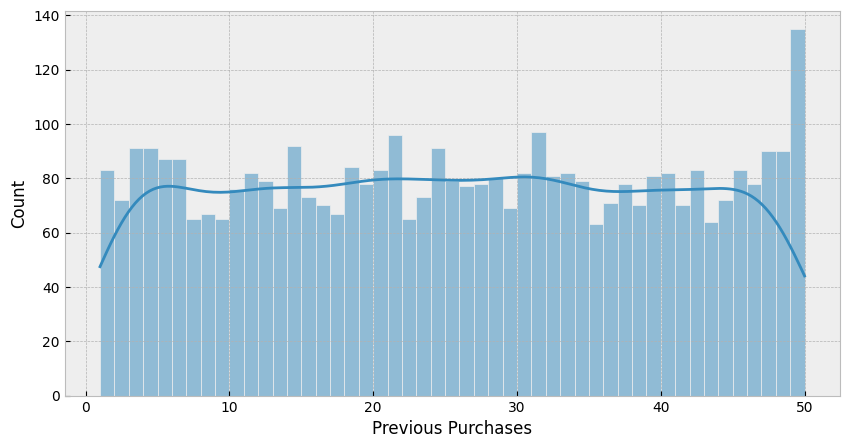

In [11]:
show_histplot('Previous Purchases')

## Categorical data

In [12]:
def show_barplot(column, data=data):
    data_vc = data[column].value_counts()
    
    fig_width = len(data_vc.index) + 5
    
    plt.figure(figsize=(fig_width, 5))
    sns.barplot(data_vc, palette='muted')
    
    plt.show()


for col in data.columns:
    if data[col].nunique() <= 10:
        print(col)

Gender
Category
Size
Season
Subscription Status
Shipping Type
Discount Applied
Promo Code Used
Payment Method
Frequency of Purchases


### *Gender*

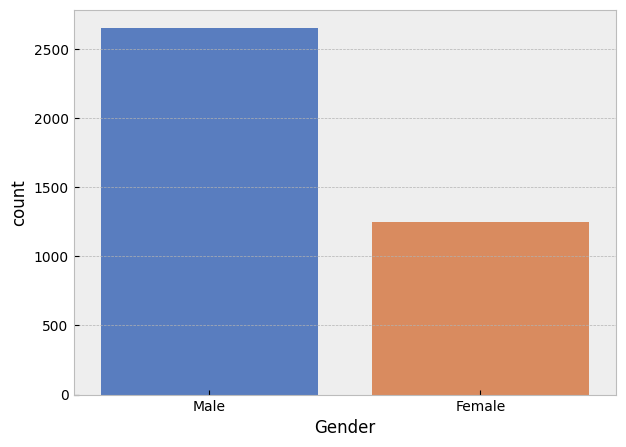

In [13]:
show_barplot('Gender')

### *Category*

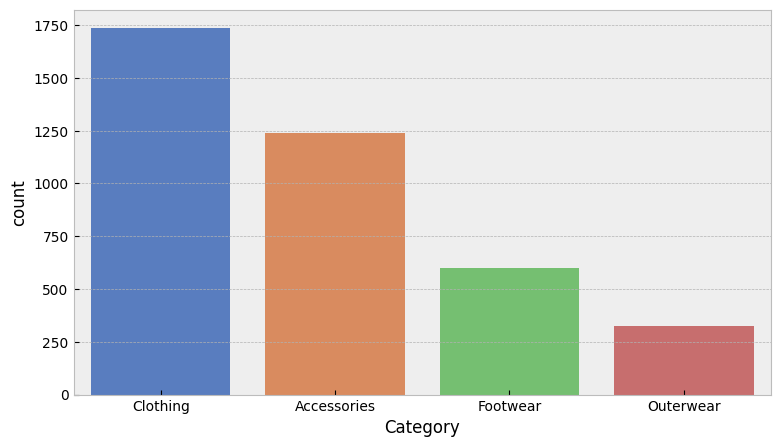

In [14]:
show_barplot('Category')

### *Size*

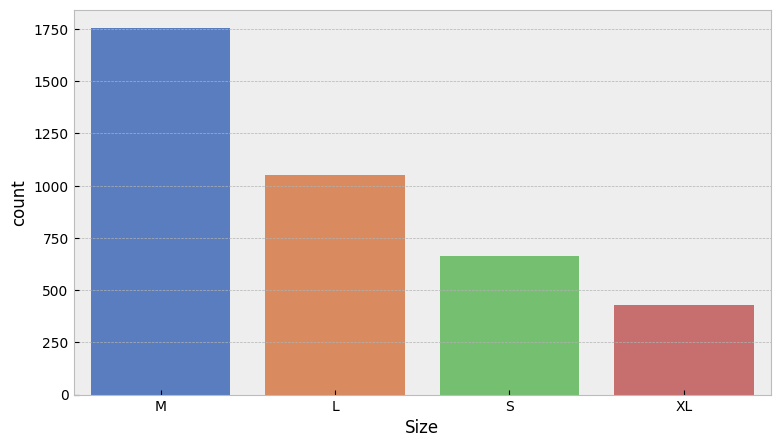

In [15]:
show_barplot('Size')

### *Season*

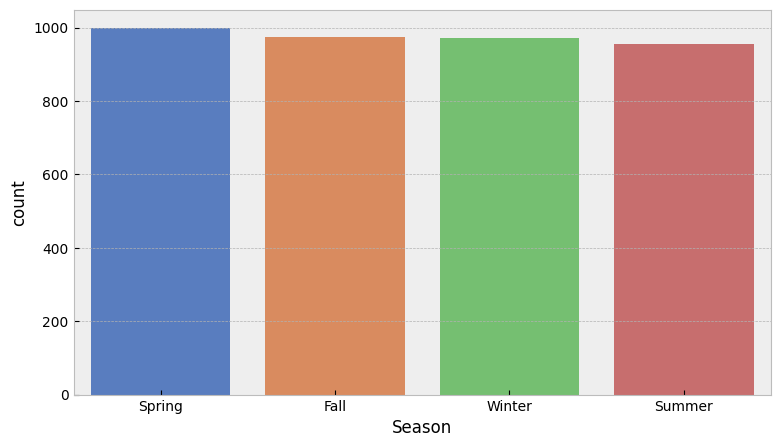

In [16]:
show_barplot('Season')

### *Subscription Status*

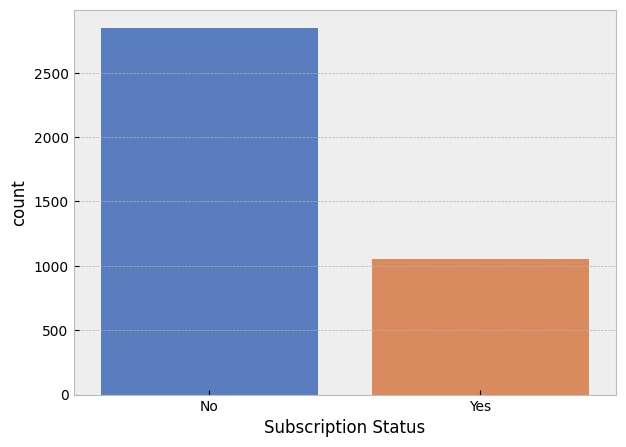

In [17]:
show_barplot('Subscription Status')

### *Shipping Type*

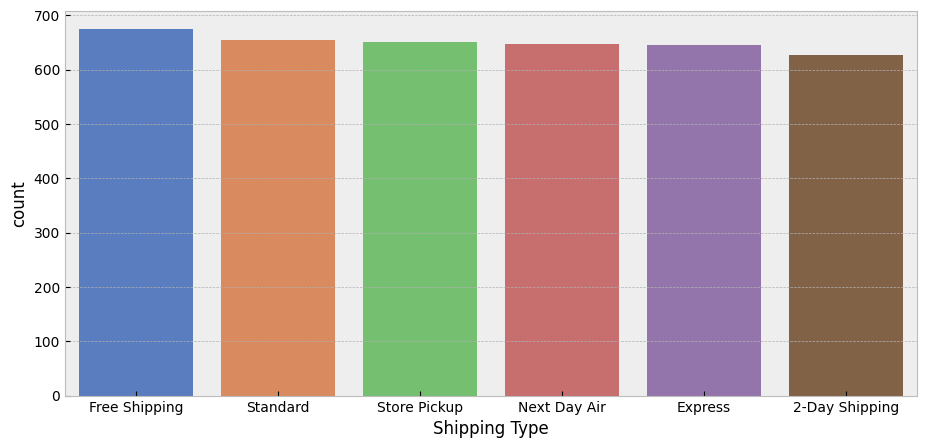

In [18]:
show_barplot('Shipping Type') 

### *Discount Applied*

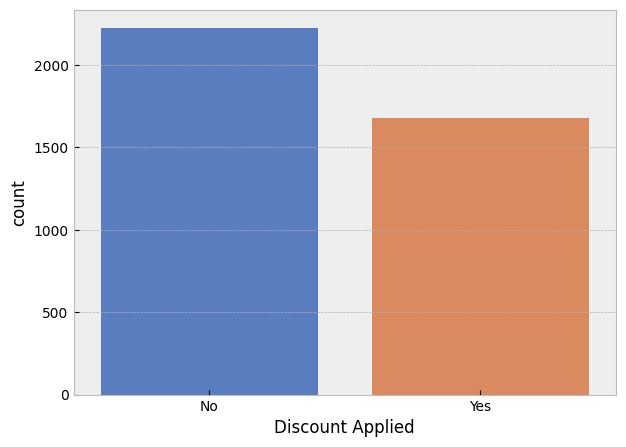

In [19]:
show_barplot('Discount Applied')

### *Promo Code Used*

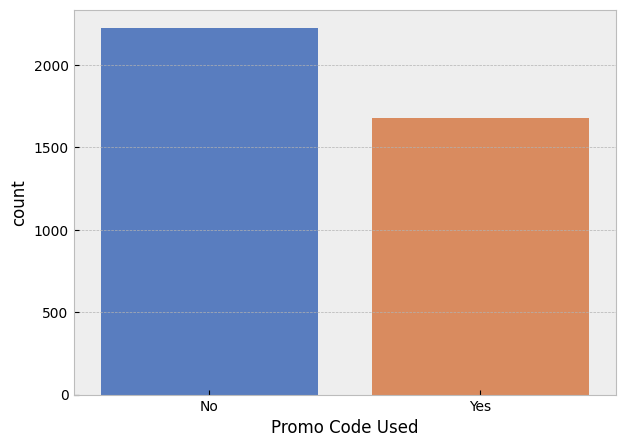

In [20]:
show_barplot('Promo Code Used')

### *Payment Method*

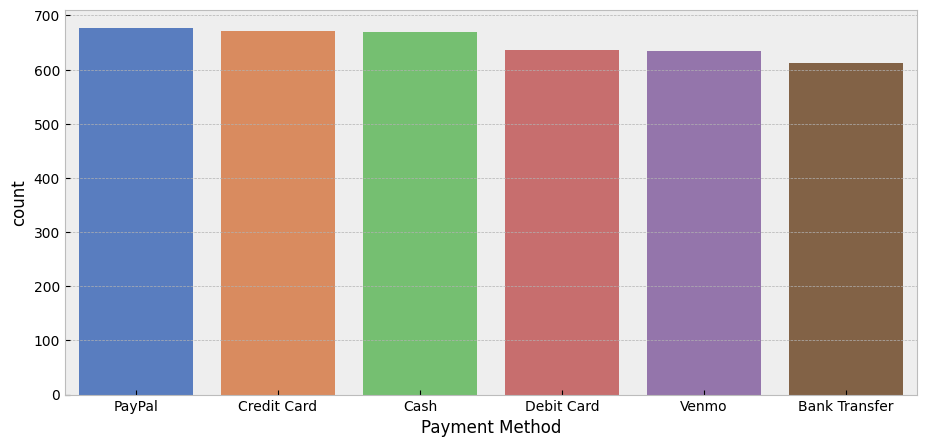

In [21]:
show_barplot('Payment Method')

### *Frequency of Purchases*

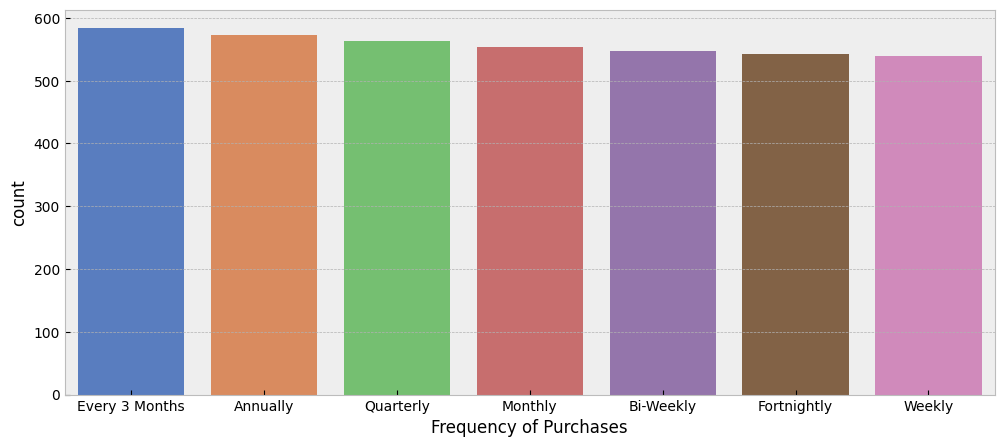

In [22]:
show_barplot('Frequency of Purchases') 

## Other type data

In [23]:
for col in data.columns:
    if (data[col].nunique() > 10) and (data[col].dtype == 'object'):
        print(col)

Item Purchased
Location
Color


### *Item Purchased*

In [24]:
data['Item Purchased'].value_counts()

Item Purchased
Blouse        171
Jewelry       171
Pants         171
Shirt         169
Dress         166
Sweater       164
Jacket        163
Belt          161
Sunglasses    161
Coat          161
Sandals       160
Socks         159
Skirt         158
Shorts        157
Scarf         157
Hat           154
Handbag       153
Hoodie        151
Shoes         150
T-shirt       147
Sneakers      145
Boots         144
Backpack      143
Gloves        140
Jeans         124
Name: count, dtype: int64

### *Location*

In [25]:
data['Location'].value_counts().index

Index(['Montana', 'California', 'Idaho', 'Illinois', 'Alabama', 'Minnesota',
       'Nebraska', 'New York', 'Nevada', 'Maryland', 'Delaware', 'Vermont',
       'Louisiana', 'North Dakota', 'Missouri', 'West Virginia', 'New Mexico',
       'Mississippi', 'Indiana', 'Georgia', 'Kentucky', 'Arkansas',
       'North Carolina', 'Connecticut', 'Virginia', 'Ohio', 'Tennessee',
       'Texas', 'Maine', 'South Carolina', 'Colorado', 'Oklahoma', 'Wisconsin',
       'Oregon', 'Pennsylvania', 'Washington', 'Michigan', 'Alaska',
       'Massachusetts', 'Wyoming', 'Utah', 'New Hampshire', 'South Dakota',
       'Iowa', 'Florida', 'New Jersey', 'Hawaii', 'Arizona', 'Kansas',
       'Rhode Island'],
      dtype='object', name='Location')

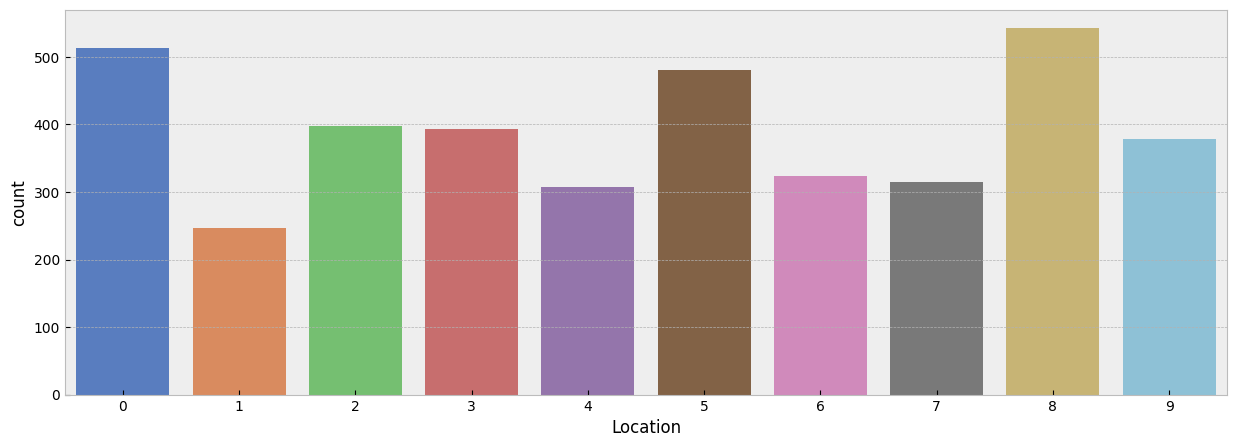

In [29]:
def change_location(x):
    zones = {0: ['New Jersey', 'Connecticut', 'Rhode Island', 'Massachusetts', 'New Hampshire', 'Vermont', 'Maine'], 
             1: ['Delaware', 'Pennsylvania', 'New York'], 
             2: ['Maryland', 'Virginia', 'West Virginia', 'North Carolina', 'South Carolina'], 
             3: ['Mississippi', 'Tennessee', 'Alabama', 'Georgia', 'Florida'], 
             4: ['Michigan', 'Indiana', 'Ohio', 'Kentucky'], 
             5: ['Montana', 'North Dakota', 'South Dakota', 'Minnesota', 'Iowa', 'Wisconsin'], 
             6: ['Nebraska', 'Kansas', 'Missouri', 'Illinois'], 
             7: ['Texas', 'Oklahoma', 'Arkansas', 'Louisiana'], 
             8: ['Idaho', 'Wyoming', 'Utah', 'Nevada', 'Colorado', 'Arizona', 'New Mexico'], 
             9: ['Washington', 'Oregon', 'California', 'Alaska', 'Hawaii']}
    
    for k, v in zones.items():
        if x in v:
            x = k
    
    return x


locs_vc = (data['Location']
           .apply(change_location)
           .value_counts())

plt.figure(figsize=(15, 5))
sns.barplot(locs_vc, palette='muted')

plt.show()

### *Color*

In [27]:
data['Color'].value_counts()

Color
Olive        177
Yellow       174
Silver       173
Teal         172
Green        169
Black        167
Cyan         166
Violet       166
Gray         159
Maroon       158
Orange       154
Charcoal     153
Pink         153
Magenta      152
Blue         152
Purple       151
Peach        149
Red          148
Beige        147
Indigo       147
Lavender     147
Turquoise    145
White        142
Brown        141
Gold         138
Name: count, dtype: int64

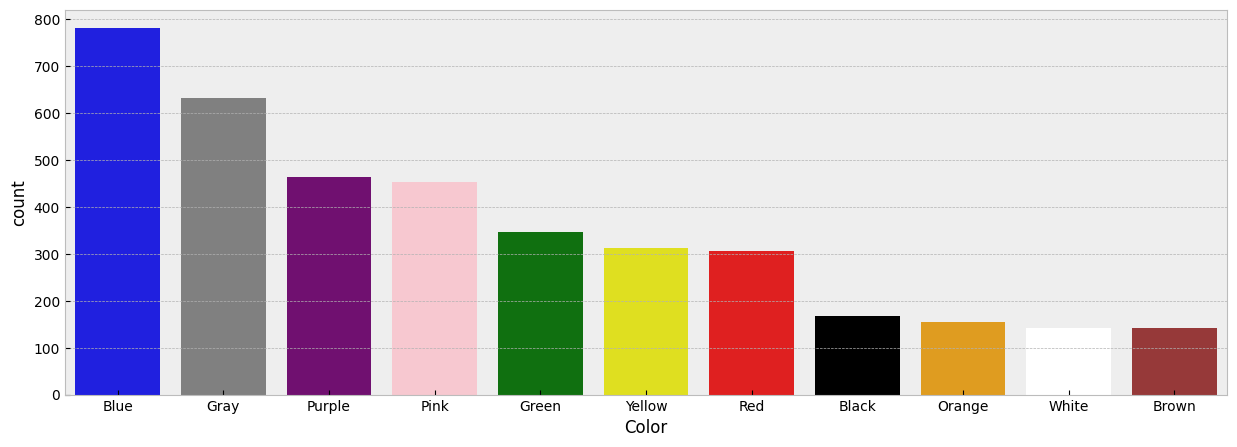

In [28]:
def change_color(x):
    colors = {'Red': ['Maroon'], 
              'Yellow': ['Gold'], 
              'Green': ['Olive'], 
              'Blue': ['Teal', 'Cyan', 'Indigo', 'Turquoise'],
              'Purple': ['Violet', 'Lavender'], 
              'Pink': ['Magenta', 'Peach'], 
              'Gray': ['Silver', 'Charcoal', 'Beige']}
    
    for k, v in colors.items():
        if x in v:
            x = k
    
    return x


colors_vc = (data['Color']
             .apply(change_color)
             .value_counts())

plt.figure(figsize=(15, 5))
sns.barplot(colors_vc, palette=colors_vc.index.tolist())

plt.show()